[View in Colaboratory](https://colab.research.google.com/github/pilipolio/learn-pytorch/blob/master/201804_TSNE.ipynb)


# Stochastic neighbour embedding

 * http://lvdmaaten.github.io/tsne
 * [Original article](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and author [presentation video](https://www.youtube.com/watch?v=RJVL80Gg3lA)

Approximating a conditional probability distribution by learning embeddings $y_i$ of each data points
$$ p_{j|i} \approx q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) }$$
    

In [1]:
! pip install torch
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

torch.__version__

    100% |████████████████████████████████| 484.0MB 15kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5cb88000 @  0x7fb1c5e621c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


'0.4.0'

## Toy model

Transition probabilities between 3 states

In [182]:
n = 3
d = 2

points_to_clusters = [0, 1, 2]

p_ij = np.array([
    [.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

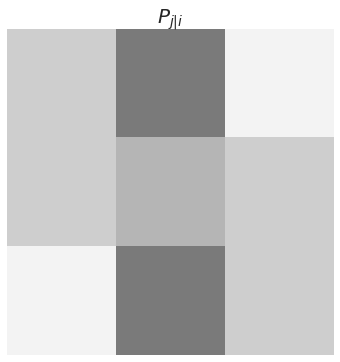

In [183]:
def plot_matrix(probability_matrix, ax=None, title=None, cmap='Greys', **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(probability_matrix, cmap=cmap, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title, fontsize=20)


plot_matrix(p_ij, title='$P_{j|i}$', vmin=0, vmax=1)

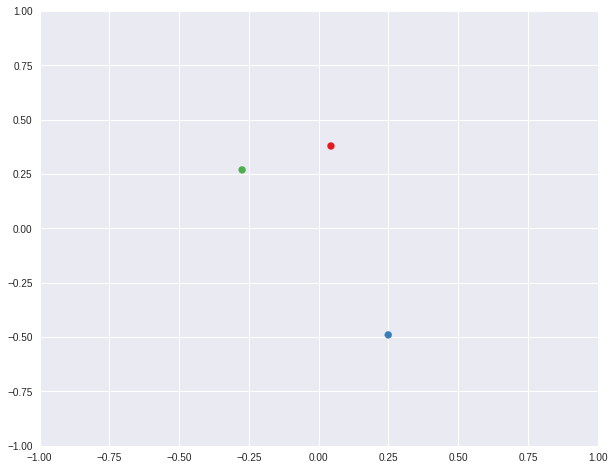

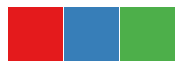

In [196]:
import seaborn as sns
from matplotlib.colors import ListedColormap

y_i = np.random.normal(scale=.25, size=(n, d))

def plot(y_i, points_to_clusters, ax=None, marker='o'):
    palette = sns.color_palette("Set1", np.max(points_to_clusters) + 1)
    cmap = ListedColormap(palette)
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))
        sns.palplot(palette)

    ax.scatter(*y_i.T, c=points_to_clusters, marker=marker, cmap=cmap)
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]);
    return ax

plot(y_i, points_to_clusters);

In [197]:
# Numpy broadcasting to perform cartesian product of nxn euclidean distances
# https://stackoverflow.com/a/37903795/230286

# (n x 1 x d) - (n x d) -> (n x n x d)
squared_distances_i_j_k = np.power(y_i[:, np.newaxis, :] - y_i, 2)
pairwise_squared_distances_i_j = squared_distances_i_j_k.sum(axis=2)

pairwise_squared_distances_i_j

array([[0.        , 0.79677742, 0.11349702],
       [0.79677742, 0.        , 0.85015431],
       [0.11349702, 0.85015431, 0.        ]])

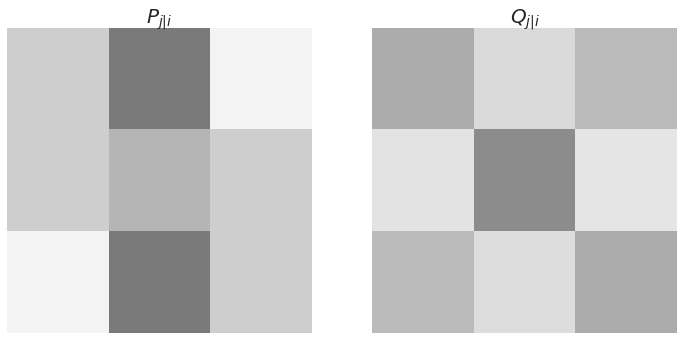

In [198]:
unnormalized_q_i_j = np.exp(-pairwise_squared_distances_i_j)
q_i_j = unnormalized_q_i_j / unnormalized_q_i_j.sum(axis=1)

f, (left, right) = plt.subplots(1, 2, figsize=(12, 8))
plot_matrix(p_ij, ax=left, title='$P_{j|i}$', vmin=0, vmax=1)
plot_matrix(q_i_j, ax=right, title='$Q_{j|i}$', vmin=0, vmax=1)


### Pytorch equivalent

In [199]:
import torch
import torch.autograd
from torch.autograd import Variable

In [200]:
def pairwise_squared_distances(y_i: torch.Tensor):
    # (n x 1 x d) - (n x d) -> (n x n x d)
    squared_distances_ijk = (y_i[:, None, :] - y_i) ** 2
    pairwise_squared_distances_ij = squared_distances_ijk.sum(2)    
    return pairwise_squared_distances_ij

pairwise_squared_distances(torch.from_numpy(y_i))

tensor([[ 0.0000,  0.7968,  0.1135],
        [ 0.7968,  0.0000,  0.8502],
        [ 0.1135,  0.8502,  0.0000]], dtype=torch.float64)

In [201]:
def approximated_probs(embeddings_i: torch.Tensor):
    pairwise_squared_distances_ij = pairwise_squared_distances(embeddings_i)
    unnormalized_q_ij = (-pairwise_squared_distances_ij).exp()
    q_ij = unnormalized_q_ij / unnormalized_q_ij.sum(1)

    return q_ij

approximated_probs(torch.from_numpy(y_i))

tensor([[ 0.4267,  0.2400,  0.3848],
        [ 0.1924,  0.5324,  0.1842],
        [ 0.3809,  0.2275,  0.4310]], dtype=torch.float64)

### Quick primer on [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

 * roots in information theory (relative entropy)
 * "measures how one probability distribution diverges from a second distribution".
 * Well behaved cost function (differentiable) 
 * Not a distance because assymetric:

![title](https://image.slidesharecdn.com/vbtechtalk-150727192410-lva1-app6892/95/variational-inference-13-638.jpg?cb=1438030914)

### Back to the T-SNE cost function

KL divergence between $P_i$ and $Q_i$

Equation (3)

$$
\sum_i \text{KL} (P_i||Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$

In [202]:
q_ij = approximated_probs(torch.from_numpy(y_i))
q_ij

tensor([[ 0.4267,  0.2400,  0.3848],
        [ 0.1924,  0.5324,  0.1842],
        [ 0.3809,  0.2275,  0.4310]], dtype=torch.float64)

tensor([[-0.1057,  0.5497, -0.1347],
        [ 0.1333, -0.1144,  0.1463],
        [-0.1337,  0.5818, -0.1087]], dtype=torch.float64)

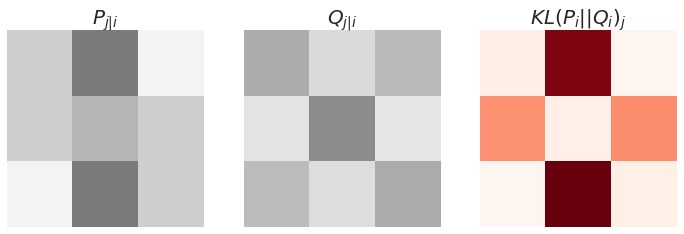

In [203]:
def kl_divergence_ij(p_ij: torch.Tensor, q_ij: torch.Tensor):
    return (p_ij * (p_ij.log() - q_ij.log()))

kl_ij = kl_divergence_ij(torch.from_numpy(p_ij), q_ij)

f, (left, middle, right) = plt.subplots(1, 3, figsize=(12, 8))

plot_matrix(p_ij, ax=left, title='$P_{j|i}$', vmin=0, vmax=1)
plot_matrix(q_ij, ax=middle, title='$Q_{j|i}$', vmin=0, vmax=1)
plot_matrix(kl_ij, ax=right, title='$ KL (P_i||Q_i)_{j}$', cmap='Reds')

kl_ij

### Derivating gradients

Replicating Annex A but for the SNE assymetric case

$$ q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) } $$ 

Defining intermediate variables:

$$ d_{ij} = ||y_i - y_j||^2 $$

$$ Z = \sum_{k\neq l} \exp ( - d_{kl}) $$

$$ \frac{\partial C}{\partial y_i} = \sum_j (\frac{\partial C}{\partial d_{ij}} + \frac{\partial C}{\partial d_{ji}}) (y_i - y_j) $$


From the KL definition (1st part constant):

$$ \frac{\partial C}{\partial d_{ij}} = - \sum_{k \neq l} p_{k|l} \frac{\partial (\log q_{k|l}) }{\partial d_{ij}} $$

$$ = - \sum_{k \neq l} p_{k|l} \frac{\partial (\log q_{k|l} Z - \log Z) }{\partial d_{ij}} $$

$$ = - \sum_{k \neq l} \Big( \underbrace{p_{k|l} \frac{\partial d_{kl}^2}{\partial d_{ij}}}_{1)} - \underbrace{ p_{k|l} Z^{-1} \frac{\partial Z}{\partial d_{ij}}}_{ 2) } \Big) $$

1) gradient $\frac{\partial d_{kl}^2}{\partial d_{ij}}$ only non-zero when $k=i$ and $l=j$

2) $Z^{-1} \frac{\partial Z}{\partial d_{ij}} = q_{i|j}$ and then $ \sum_{k\neq l} p_{k|l} = 1$

$$ \frac{\partial C}{\partial d_{ij}} = - 2 (p_{i|j} - q_{i|j}) $$

$$ \frac{\partial C}{\partial y_i} = 2\sum_j (p_{j|i} -  q_{j|i} + p_{i|j} - q_{i|j}) (yi - yj) $$

### Physical interpretation

"the gradient may be interpreted as the resultant force created by a set of springs between the map point $y_i$ and all other map points $y_j$ "

In [204]:
q_ij = approximated_probs(torch.from_numpy(y_i)).numpy()

spring_tensions_ij = (p_ij - q_ij + p_ij.T - q_ij.T)

gradients_ij = ((y_i - y_i[:, np.newaxis, :]) * spring_tensions_ij[:, :, np.newaxis])
print(gradients_ij.shape)
gradients_ij

(3, 3, 2)


array([[[-0.        , -0.        ],
        [ 0.09599685, -0.4062298 ],
        [ 0.18016495,  0.06215066]],

       [[-0.09599685,  0.4062298 ],
        [-0.        , -0.        ],
        [-0.25573219,  0.3705105 ]],

       [[-0.18016495, -0.06215066],
        [ 0.25573219, -0.3705105 ],
        [-0.        , -0.        ]]])

In [206]:
palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]

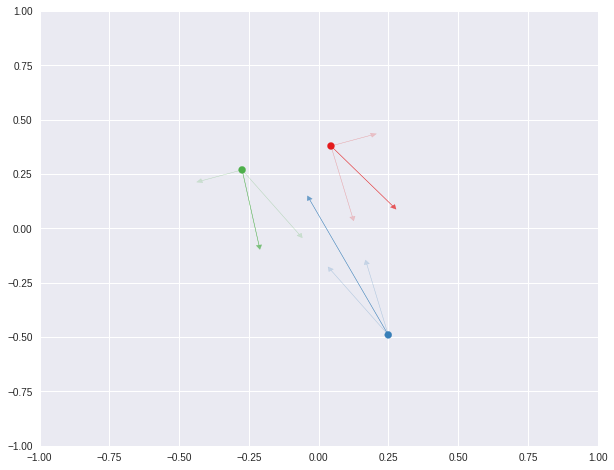

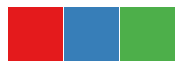

In [209]:
palette = sns.color_palette("Set1", np.max(points_to_clusters) + 1)

ax = plot(y_i, points_to_clusters);
arrow_params = dict(head_width=0.02, head_length=0.02)
n = p_ij.shape[0]
learning_rate = .8

gradients_i = gradients_ij.sum(axis=1)
for i in range(n):
    ax.arrow(*y_i[i], *learning_rate * gradients_i[i], color=palette[i], **arrow_params, alpha=.7)
    for j in set(range(n)).difference([i]):
        ax.arrow(*y_i[i], *learning_rate * gradients_ij[i][j], color=palette[i], **arrow_params, alpha=.2)

## Gradient through loss back-propagation

In [117]:
current_y_i = y_i

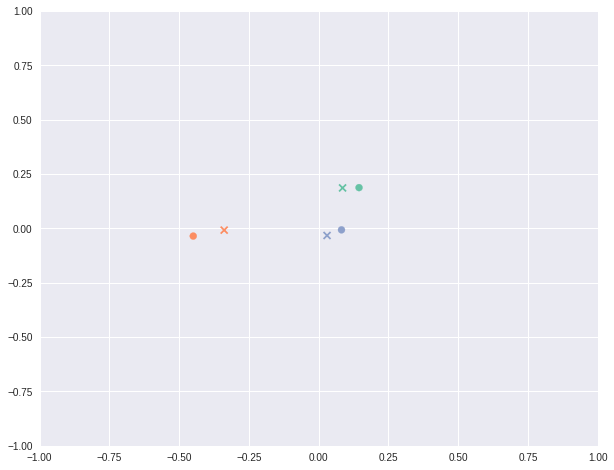

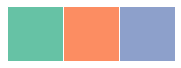

In [118]:
def updated_embeddings(current_y_i: np.array, p_ij: np.array, learning_rate=.2):
    embeddings_i = Variable(torch.from_numpy(current_y_i), requires_grad=True)
    
    loss = kl_divergence(torch.from_numpy(p_ij), q_ij=approximated_probs(embeddings_i))

    loss.backward()
    embeddings_gradient_i = embeddings_i.grad.data.numpy()

    return current_y_i + learning_rate * embeddings_gradient_i

ax = plot(current_y_i, points_to_clusters)

current_y_i = updated_embeddings(current_y_i, p_ij)

plot(current_y_i, points_to_clusters, ax, marker='x')

## Illustration on a slightly more interesting dataset

$n$ individual data points spread accross 3 clusters, $p_ij$ depends on the cluster

In [119]:
inter_p_ij = np.array(
    [[.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

n = 75
points_to_clusters = np.repeat([0, 1, 2], repeats=25)

p_ij = np.vstack([
    np.repeat(inter_p_ij[0], repeats=25),
    np.repeat(inter_p_ij[1], repeats=25),
    np.repeat(inter_p_ij[2], repeats=25)])[points_to_clusters]

p_ij = p_ij / p_ij.sum(1)

points_to_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [120]:
y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i

print(p_ij.shape)
print(current_y_i.shape)

(75, 75)
(75, 2)


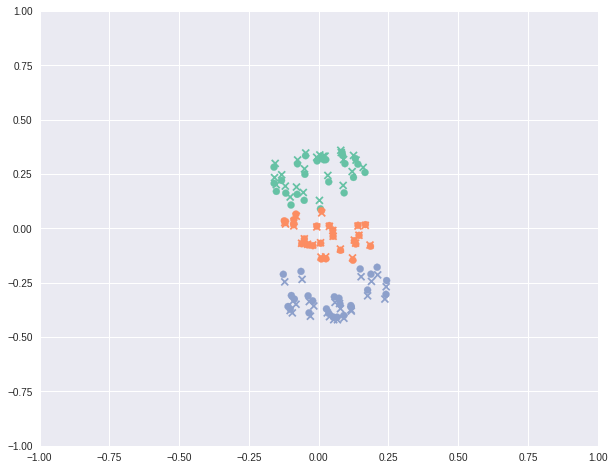

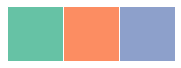

In [141]:
ax = plot(current_y_i, points_to_clusters)

updated_y_i = updated_embeddings(current_y_i, p_ij)

plot(updated_y_i, points_to_clusters, ax, marker='x')

current_y_i = updated_y_i 

## City to city distances

https://www.maxmind.com/en/free-world-cities-database

In [142]:
import pandas as pd

cities = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_name.txt', sep=',', skiprows=2, names=['city', 'state'])\
  .assign(state=lambda _:_.state.str.strip())\
  .assign(state_index=lambda _:_.state.astype('category').cat.codes)

cities.head(10)

,city,state,state_index
0,Youngstown,OH,30
1,Yankton,SD,37
2,Yakima,WA,42
3,Worcester,MA,16
4,Wisconsin Dells,WI,43
5,Winston-Salem,NC,24
6,Winnipeg,MB,17
7,Winchester,VA,40
8,Wilmington,NC,24
9,Wilmington,DE,7


,Youngstown,Yankton,Yakima,Worcester,Wisconsin Dells,Winston-Salem,Winnipeg,Winchester,Wilmington,Wilmington,...,Roanoke,Richmond,Richmond,Richfield,Rhinelander,Reno,Regina,Red Bluff,Reading,Ravenna
Youngstown,0,966,1513,2964,1149,927,1611,1510,390,466,...,1018,168,565,1700,1636,2019,1458,1564,2871,348
Yankton,966,0,2410,1520,1817,729,686,290,1823,168,...,548,1127,432,2265,558,571,943,198,1917,2541
Yakima,1513,2410,0,604,481,2742,1833,826,214,1618,...,752,486,590,2132,1095,2154,1211,2217,2673,1570
Worcester,2964,1520,604,0,595,1289,1446,466,1139,430,...,1861,861,499,1408,986,2719,1437,769,1038,2343
Wisconsin Dells,1149,1817,481,595,0,494,550,2641,765,934,...,216,1994,324,2187,260,2586,1974,2352,2243,691


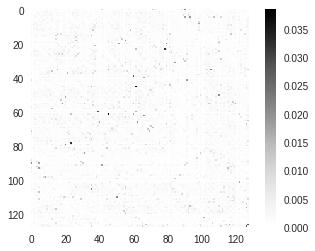

In [143]:
distances = pd.read_fwf('https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_dist.txt', skiprows=6).iloc[:, 1:]
distances.index = cities.city.values
distances.columns = cities.city.values

n = distances.shape[0]

similarities = 1 / (1 + distances.values) 
similarities[range(n), range(n)] = 0

p_ij = (similarities.T / similarities.sum(axis=0)).T

plt.imshow(similarities, cmap='Greys')
plt.colorbar();

distances.head()

In [144]:
points_to_clusters = cities.state_index.values

y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i


print(p_ij.shape)
print(current_y_i.shape)

(128, 128)
(128, 2)


In [145]:
def plot_cities(embeddings, points_to_clusters):
  f, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(*embeddings.T, c=points_to_clusters, marker='o', cmap=cmap)

  for name, xy in zip(cities.state.values, embeddings):
    ax.text(*xy, s=name)

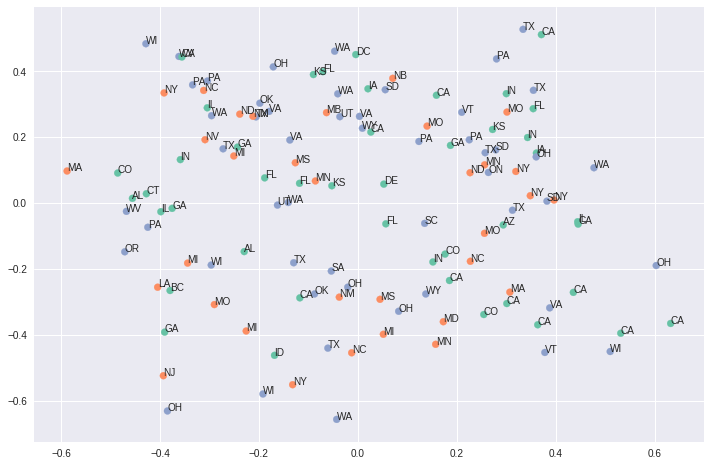

In [180]:
updated_y_i = updated_embeddings(current_y_i, p_ij, learning_rate=.5)

plot_cities(updated_y_i, points_to_clusters)

current_y_i = updated_y_i


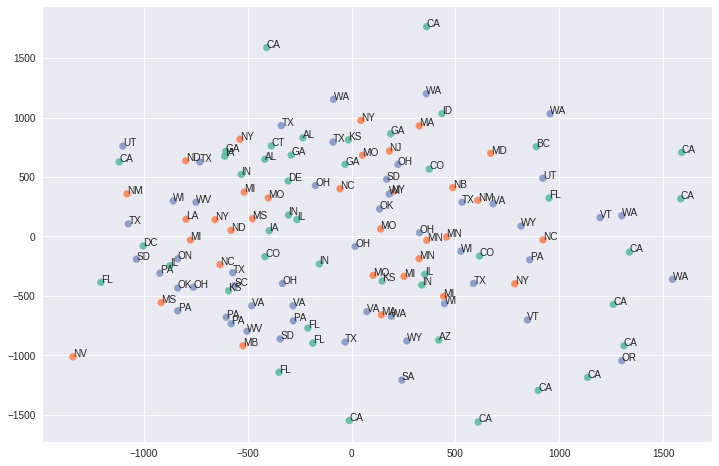

In [160]:
from sklearn import manifold

mds = manifold.MDS(dissimilarity='precomputed', n_components=2)

mds_embeddings = mds.fit_transform(distances)

plot_cities(mds_embeddings, points_to_clusters)


In [161]:
ca_cities = cities[cities.state == 'CA']

distances.iloc[ca_cities.index, ca_cities.index]

,Weed,Stockton,Santa Rosa,Santa Barbara,Santa Ana,San Jose,San Francisco,San Diego,San Bernardino,Salinas,Sacramento,Red Bluff
Weed,0,2295,3125,1265,2179,1825,1753,1398,1246,3022,2399,3166
Stockton,2295,0,3120,2655,1144,1787,2294,1760,1381,1812,1912,2015
Santa Rosa,3125,3120,0,1778,1160,3186,2189,2147,2563,2662,1883,656
Santa Barbara,1265,2655,1778,0,2441,1755,810,2149,2464,1663,1737,2658
Santa Ana,2179,1144,1160,2441,0,2632,1729,3019,2090,3004,2128,2908
San Jose,1825,1787,3186,1755,2632,0,2606,1250,2961,2936,2117,2798
San Francisco,1753,2294,2189,810,1729,2606,0,1751,1176,2880,2732,1761
San Diego,1398,1760,2147,2149,3019,1250,1751,0,2397,2781,858,2256
San Bernardino,1246,1381,2563,2464,2090,2961,1176,2397,0,2273,3067,2009
Salinas,3022,1812,2662,1663,3004,2936,2880,2781,2273,0,2751,2848


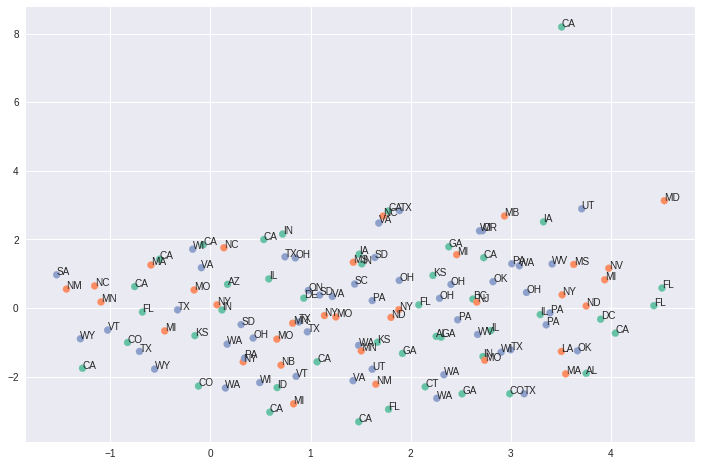

In [163]:
tsne = manifold.TSNE(metric='precomputed', n_components=2)

tsne_embeddings = tsne.fit_transform(distances)

plot_cities(tsne_embeddings, points_to_clusters)


In [0]:
manifold.TSNE?